## Introduction

This notebook is an implementation of the greedy poisoning attack on regression models as described in Kornaropoulos et. al - *The Price of Tailoring the Index to Your Data: Poisoning Attacks on Learned Index Structures* (paper available on [Arxiv](https://arxiv.org/abs/2008.00297))

**TODO**: 
* Write proper documentation
* Speed-up implementation of Algorithm 1

In [260]:
import csv
import numpy as np
import pandas as pd
from itertools import groupby

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import matplotlib.pyplot as plt  
import warnings, datetime
import scipy.stats as ss

## Greedy Poisoning Regression CDF

The following code implements **Algorithm 1 (Greedy Poisoning Regression CDF)** as described in the paper "*The Price of Tailoring the Index to Your Data: Poisoning Attacks on Learned Index Structures*".

In [261]:
# Extracts non-occupied keys for a given sequence
def extract_non_occupied_keys(keyset):
    n = keyset.shape[0]
    
    lower_bound = int(keyset[0]-1)
    upper_bound = int(keyset[n-1]+1)
    
    non_occupied_keys = []
    for i in range(lower_bound, upper_bound + 1):
        if i not in keyset:
            non_occupied_keys.append(i)
        
    return non_occupied_keys

# Groups a list of keys into subsequences of consecutive keys 
def extract_seq(seq):
    return [
        [x for _, x in g]
        for k, g in groupby(
            enumerate(seq), 
            lambda i_x : i_x[0] - i_x[1]
        )
    ]   

# Extract the endpoints of each subsequence
def extract_endpoints(subsequences):
    endpoints = []
    for sequence in subsequences:
        if len(sequence) == 1:
            endpoints.append(sequence[0])
        else:
            endpoints.append(sequence[0])
            endpoints.append(sequence[len(sequence)-1])
            
    return endpoints

# Partition the non-occupied keys, i.e., keys not in K ∪ P, into subsequences such that each subsequence consists of consecutive non-occupied keys;
def partition_non_occupied_keys(K, P):
    keyset = np.append(K, list(P))
    keyset = np.sort(keyset)

    non_occupied_keys = extract_non_occupied_keys(keyset)
    
    subsequences = extract_seq(non_occupied_keys)
    endpoints = extract_endpoints(subsequences)
    return np.array(endpoints)

# Compute the rank that key S(i) would have if it was inserted in K ∪ P and assign this rank as the i-th element of the new sequence
def compute_rank_for_endpoints(endpoints, keyset):
    computed_rank_for_endpoint = []
    
    for endpoint in endpoints:
        keyset_extended = np.append(keyset, endpoint)
        rank = list(ss.rankdata(keyset_extended))
        # extract rank for the last element in the list (endpoint)
        computed_rank_for_endpoint.append(int(rank[len(rank)-1]))
    
    return computed_rank_for_endpoint
    

In [262]:
import operator
from statistics import mean

def obtain_poisoning_keys(p, keyset, rankset):
    # Total number of elements
    n = keyset.shape[0]

    # Number of posoning keys p
    P = p * n
    poisoning_keys = set()

    for j in range(int(P)):
        # Partition the non-occupied keys into subsequences such that each subsequence consists of consecutive non-occupied keys;
        # Extract the endpoints of each subsequence and sort them to construct the new sequence of endpoints S(i), where i <= 2(n + j);
        endpoints = partition_non_occupied_keys(keyset, poisoning_keys)

        # Compute the rank that key S(i) would have if it was inserted in K ∪ P and assign this rank as the i-th element of the new sequence T (i), where i <= 2(n + j) ;
        list_rank = compute_rank_for_endpoints(endpoints, keyset)

        # Compute the effect of choosing S(1) as a poisoning key and inserting it to K ∪ P with the appropriate rank adjustments. 
        # Specifically, evaluate the sequences each of which is the mean M for a different variable, e.g., K, R, KR. Compute MK (1), MK2 (1), MKR(1), and L(1) ;
        S = endpoints
        T = list_rank
        
        delta_S = {}
        M_K = {}
        M_K_square = {}
        M_R = {}
        M_R_square = {}
        M_KR = {}
        L = {}
        
        # Calculate M_K(1), M_R(1) etc.
        current_keyset = np.append(keyset, S[0])
        M_K[0] = np.mean(keyset)

        current_rankset = np.append(rankset, T[0])
        M_R[0] = np.mean(rankset)

        M_K_square[0] = np.mean(keyset**2)

        M_R_square[0] = np.mean(rankset**2)

        M_KR[0] = np.mean(keyset*rankset)

        nominator = (M_KR[0] - (M_K[0] * M_R[0]))**2
        denominator = M_K_square[0] - (M_K[0])**2
        L[0] = - (nominator / denominator) + M_R_square[0] - (M_R[0])**2

        for i in range(1, len(endpoints)-1):
            # Calculate M_K(i), M_R(i) etc.
            delta_S[i] = S[i+1] - S[i] 

            M_K[i] = M_K[i-1] + delta_S[i] / (n) 
            M_K_square[i] = M_K_square[i-1] + (( 2 * S[i] + delta_S[i]) * delta_S[i]) / (n + 1) 

            M_R[i] = (n + 2) / 2
            M_R_square[i] = ((n+2)*(2*n+3)) / 6
            M_KR[i] = M_KR[i-1] + ( T[i-1] * delta_S[i]) / (n + 1)

            nominator = (M_KR[i] - M_K[i]*M_R[i])**2
            denominator = M_K_square[i] - (M_K[i])**2
            L[i] = - (nominator / denominator) + M_R_square[i] - (M_R[i])**2

        # get argmax of items in L
        optimal_key_index = max(L.items(), key=operator.itemgetter(1))[0]
        poisoning_keys.add(S[optimal_key_index])
    
    return poisoning_keys

## Linear regression with non-poisoned keys

In [263]:
df=pd.read_csv('data/random_500.csv', sep=',',header=None)

X = np.array(df[0]).reshape(-1, 1)
y = np.array(df[1])
regressor_legitimate = LinearRegression()
regressor_legitimate.fit(X, y) 

y_pred = regressor_legitimate.predict(X)
mse_legitimate = metrics.mean_squared_error(y, y_pred)

In [264]:
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))  

Mean Squared Error: 14.705531571425096


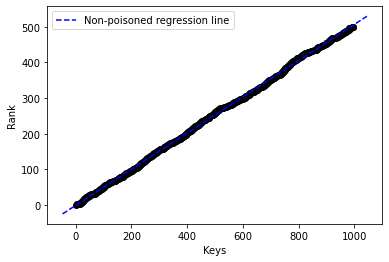

In [265]:
def abline(slope, intercept, color, label):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color=color, label = label)
    plt.legend()
    plt.xlabel('Keys')
    plt.ylabel('Rank')

# Plot outputs
plt.scatter(X, y,  color='black')
abline(regressor_legitimate.coef_, regressor_legitimate.intercept_, color="blue", label="Non-poisoned regression line")
 
plt.show()

## Linear regression with poisoned keys

In [266]:
poisoning_keys = obtain_poisoning_keys(p = 0.2, keyset=X, rankset=y)

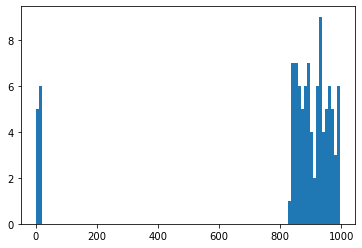

In [267]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

def plot_distribution_of_poisoning_keys(poisoning_keys):
    # we observe that poisoning keys are densly populated together
    plt.hist(poisoning_keys, bins = 100, range=[0, df[0][len(df)-1]])
    plt.show()

plot_distribution_of_poisoning_keys(poisoning_keys)

In [268]:
X_poisoned = np.append(X, list(poisoning_keys))
y_poisoned = ss.rankdata(X_poisoned)

In [269]:
X_poisoned = X_poisoned.reshape(-1,1)
regressor_poisoned = LinearRegression()
regressor_poisoned.fit(X_poisoned, y_poisoned)  

y_poisoned_pred = regressor_poisoned.predict(X_poisoned)

In [270]:
print("------------------")
print('Mean Squared Error:', metrics.mean_squared_error(y_poisoned, y_poisoned_pred))  
mse_poisoned = metrics.mean_squared_error(y_poisoned, y_poisoned_pred)

------------------
Mean Squared Error: 300.3537350757655


In [271]:
ratio_loss =  mse_poisoned / mse_legitimate

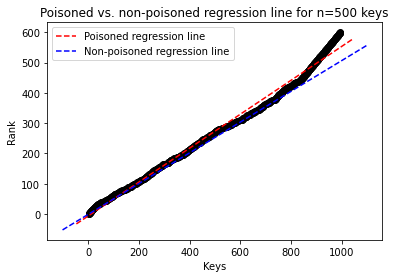

In [272]:
# Plot outputs
plt.scatter(X_poisoned, y_poisoned,  color='black')
abline(regressor_poisoned.coef_, regressor_poisoned.intercept_, color="red", label="Poisoned regression line")
abline(regressor_legitimate.coef_, regressor_legitimate.intercept_, color="blue", label="Non-poisoned regression line")
label= "Poisoned vs. non-poisoned regression line for n="+ str(X.shape[0]) + " keys"
plt.title(label=label)
plt.show()

## Experiments with different key sizes / different poisoning percentages

In [14]:
import random

def generate_uniform_data(size):
    
    data = random.sample(range(2, size * 2), size)
    data.sort()
    return data

In [15]:
dataset_sizes = [500, 1000]

for dataset_size in dataset_sizes:
    
    print("-------------------------")
    print("Dataset size: ", dataset_size)
    X = generate_uniform_data(dataset_size)
    X = np.array(X).reshape(-1, 1)
    
    y = np.linspace(1, dataset_size, num=dataset_size)

    poisoning_percentages = np.linspace(0.01, 0.15, num= 15)

    ratio_losses = []
    
    regressor_legitimate = LinearRegression()
    regressor_legitimate.fit(X, y) 

    y_pred = regressor_legitimate.predict(X)
    mse_legitimate = metrics.mean_squared_error(y, y_pred)

    for percentage in poisoning_percentages:
        poisoning_keys = obtain_poisoning_keys(p = percentage, keyset = X, rankset = y)

        #plot_poisoning_keys(poisoning_keys)

        X_poisoned = np.append(X, list(poisoning_keys))
        y_poisoned = ss.rankdata(X_poisoned)

        X_poisoned = X_poisoned.reshape(-1,1)
        regressor_poisoned = LinearRegression()
        regressor_poisoned.fit(X_poisoned, y_poisoned)  

        y_poisoned_pred = regressor_poisoned.predict(X_poisoned)

        print('Mean Squared Error:', metrics.mean_squared_error(y_poisoned, y_poisoned_pred))  
        mse_poisoned = metrics.mean_squared_error(y_poisoned, y_poisoned_pred)
        ratio_loss =  mse_poisoned / mse_legitimate

        ratio_losses.append(ratio_loss)

    plt.scatter(poisoning_percentages, ratio_losses,  color='black', marker="x")
    plt.xlabel('Poisoning Percentage')
    plt.ylabel('Ratio Loss')
    plt.show()

-------------------------
Dataset size:  500
Mean Squared Error: 20.54275738387361


ValueError: Found input variables with inconsistent numbers of samples: [600, 505]

## Greedy poisoining RMI

The following code implements **Algorithm 2 (Greedy Poisoning RMI)** as described in the paper "*The Price of Tailoring the Index to Your Data: Poisoning Attacks on Learned Index Structures*".

In [290]:
# smoothing constant alpha = {2, 3}
alpha = 1

# overall poisoning percentage
phi = 0.1

# number of second-stage models
N = 5

# key set size 
n = 500

# max. percentage number of poisoning keys per model
t = (alpha*phi*n) / (N)

initial_size = n/N


In [291]:
int(initial_size +t)

110

In [292]:
df=pd.read_csv('data/random_500.csv', sep=',',header=None)

X = np.array(df[0]).reshape(-1, 1)
y = np.array(df[1])

In [293]:
def compute_loss_rmi(X, y):
    
    regressor_poisoned = LinearRegression()
    regressor_poisoned.fit(X, y)

    y_pred = regressor_poisoned.predict(X)
    # TODO: Check if MSE is correct loss function
    mse_poisoned = metrics.mean_squared_error(y, y_pred)
    #print('Mean Squared Error:', mse_poisoned) 
    return mse_poisoned
    

In [294]:
# Split keyset and rankset into N parts and obtain poisoned keys
keyset_per_model = np.split(X, N)
rankset_per_model = np.split(y, N)

keyset_per_model_orig = keyset_per_model.copy()
rankset_per_model_orig = rankset_per_model.copy()

poisoning_keys_per_model = {}
loss_per_model = {}

# Initial volume allocation
for i in range(N):
    
    poisoning_keys_per_model[i] = obtain_poisoning_keys(p = t/100, keyset = keyset_per_model[i], rankset = rankset_per_model[i])
        
    X_poisoned = np.append(keyset_per_model[i], list(poisoning_keys_per_model[i]))
    y_poisoned = ss.rankdata(X_poisoned)

    X_poisoned = X_poisoned.reshape(-1,1)

    loss_per_model[i]  = compute_loss_rmi(X_poisoned, y_poisoned)

# Compute L_RMI by averaging the loss of second-sage models
L_RMI = np.array(list(loss_per_model.values())).mean()

In [295]:
L_RMI

6.846071882694778

In [296]:
def compute_move_forward(changeloss):


    poisoning_keys_per_model_dup = poisoning_keys_per_model.copy()
    keyset_per_model_dup = keyset_per_model.copy()


    for i in range(N-1):
    
        # (A) Add poisoning key to P_i+1
        #
        #
        X_poisoned = np.append(keyset_per_model_dup[i+1], list(poisoning_keys_per_model_dup[i+1]))
        X_poisoned = np.sort(X_poisoned)
        y_poisoned = ss.rankdata(X_poisoned)

        # obtain exactly **one** poisoning key
        p = 1/X_poisoned.shape[0]


        # obtain additional poisoning keys
        poisoning_key =  obtain_poisoning_keys(p = p, keyset = X_poisoned, rankset = y_poisoned)
        # append additional poisoning_key to set
        poisoning_keys_per_model_dup[i+1].update(poisoning_key)


        # (B) Move smallest legitimate key from (i+1)-th to i-th
        #
        #
        keyset_per_model_dup[i] = np.append(keyset_per_model_dup[i], keyset_per_model_dup[i+1][0])

        # delete smallest legitimate key
        keyset_per_model_dup[i+1] = np.delete(keyset_per_model_dup[i+1], 0)


        # (C) Remove poosoning key from P_i
        #
        #
        removed_poisoning_key = poisoning_keys_per_model_dup[i].pop()

        # Compute current loss_RMI
        loss_per_model_changed = {}

        for j in range(N-1):
            X_poisoned = np.append(keyset_per_model_dup[j], list(poisoning_keys_per_model_dup[j]))
            y_poisoned = ss.rankdata(X_poisoned)

            X_poisoned = X_poisoned.reshape(-1,1)

            loss_per_model_changed[i] = compute_loss_rmi(X_poisoned, y_poisoned)


        # Compute L_RMI by averaging the loss of second-sage models
        L_RMI_changed = np.array(list(loss_per_model_changed.values())).mean()
        #print(L_RMI_changed)

        changeloss[i, i+1] = L_RMI_changed - L_RMI

    return changeloss


In [297]:
changeloss = np.zeros(shape = (N, N))
changeloss = compute_move_forward(changeloss)

In [298]:
changeloss

array([[ 0.        , -0.79854175,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.79854175,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.84307547,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.54466107],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [299]:
# Store the effect of exchange i -> i+1 in Changeloss

def compute_move_backward(changeloss):

    poisoning_keys_per_model_dup = poisoning_keys_per_model.copy()
    keyset_per_model_dup = keyset_per_model.copy()


    for i in range(N-1):

        # (A) Add poisoning key to P_i
        #
        #
        X_poisoned = np.append(keyset_per_model_dup[i], list(poisoning_keys_per_model_dup[i]))
        X_poisoned = np.sort(X_poisoned)
        y_poisoned = ss.rankdata(X_poisoned)

        p = 1/X_poisoned.shape[0]


        # obtain additional poisoning keys
        poisoning_key =  obtain_poisoning_keys(p = p, keyset = X_poisoned, rankset = y_poisoned)
        # append additional poisoning_key to set
        poisoning_keys_per_model_dup[i].update(poisoning_key)


        # (B) Move smallest legitimate key from i-th to (i+1)-th
        #
        #
        keyset_per_model_dup[i+1] = np.append(keyset_per_model_dup[i+1], keyset_per_model_dup[i][-1])

        # delete largest legitimate key
        keyset_per_model_dup[i] = np.delete(keyset_per_model_dup[i], len(keyset_per_model_dup[i]) -1)


        # (C) Remove poosoning key from P_i+1
        #
        #
        removed_poisoning_key = poisoning_keys_per_model_dup[i+1].pop()

        # Compute current loss_RMI
        loss_per_model_changed = {}

        for j in range(N-1):
            X_poisoned = np.append(keyset_per_model_dup[j], list(poisoning_keys_per_model_dup[j]))
            y_poisoned = ss.rankdata(X_poisoned)

            X_poisoned = X_poisoned.reshape(-1,1)

            loss_per_model_changed[i] = compute_loss_rmi(X_poisoned, y_poisoned)


        # Compute L_RMI by averaging the loss of second-sage models
        L_RMI_changed = np.array(list(loss_per_model_changed.values())).mean()

        changeloss[i+1, i] = L_RMI_changed - L_RMI
    
    return changeloss

In [300]:
changeloss = compute_move_backward(changeloss)

In [301]:
changeloss

array([[  0.        ,  -0.79854175,   0.        ,   0.        ,
          0.        ],
       [ -0.79854175,   0.        ,  -0.79854175,   0.        ,
          0.        ],
       [  0.        ,  -0.79854175,   0.        ,  -0.84307547,
          0.        ],
       [  0.        ,   0.        , 248.71709745,   0.        ,
         -0.54466107],
       [  0.        ,   0.        ,   0.        ,  -0.86268657,
          0.        ]])

In [302]:
# Greedy iteration that increases the loss of the RMI
from numpy import unravel_index

epsilon = 5

num_poisoning_keys = {}

for i in range(N):
    num_poisoning_keys[i] = 0

while True:

    # Find indices (i, j) that correspond to largest entry in changeloss
    i, j = unravel_index(changeloss.argmax(), changeloss.shape)
    
    print(str(i) + ", " + str(j))
    
    # Make sure indices do not violate threshold t
    if changeloss.argmax() < epsilon:
        break
        
    changeloss_max = changeloss.argmax()
    
    # Obtain new i, j parameters
    while num_poisoning_keys[j] >= t:
        changeloss[i, j] = 0

        i, j = unravel_index(changeloss.argmax(), changeloss.shape)
        print("New:")
        print(str(i) + ", " + str(j))
        
        if changeloss.argmax() < epsilon:
            break


    # if changeloss below threshold or max number of poisoning keys has been reached
    if changeloss.argmax() < epsilon or all(i > t for i in list(num_poisoning_keys.values())):
        break

    # peform change i -> j between model i and j 


    # (B) Move legitimate key from j-th to i-th
    #
    #
    if i < j:
        keyset_per_model[i] = np.append(keyset_per_model[i], keyset_per_model[j][0])
        # delete smallest legitimate key
        keyset_per_model[j] = np.delete(keyset_per_model[j], 0)
    else: 
        keyset_per_model[i] = np.append(keyset_per_model[i], keyset_per_model[j][-1])
        # delete largest legitimate key
        keyset_per_model[j] = np.delete(keyset_per_model[j], len(keyset_per_model[j])-1)

    # (A) Add poisoning key to P_j
    #
    #
    added_poisoning_key = poisoning_keys_per_model[j].pop()
    keyset_per_model[j] = np.append(keyset_per_model[j], added_poisoning_key)


    # (C) Remove one poisoning key from P_i
    #
    #
    removed_poisoning_key = poisoning_keys_per_model[i].pop()
    
    # Obtain fresh poisoning keys
    
    poisoning_keys_per_model = {}
    for k in range(N):
        keyset_per_model[k] = np.sort(keyset_per_model[k])
        rankset_per_model[k] = ss.rankdata(keyset_per_model[k])
        poisoning_keys_per_model[k] = obtain_poisoning_keys(p = t/100, keyset = keyset_per_model[k], rankset = rankset_per_model[k])
    
    
    for m in range(N):
        print(len(keyset_per_model[m]))
        
    # Update changeloss values
    changeloss = np.zeros(shape = (N, N))
    changeloss = compute_move_forward(changeloss)
    changeloss = compute_move_backward(changeloss)
    print(changeloss)
    
    num_poisoning_keys[j] += 1


3, 2
100
100
100
101
100
[[  0.           3.55219989   0.           0.           0.        ]
 [  3.48272874   0.           3.55219989   0.           0.        ]
 [  0.           3.48272874   0.           4.39997336   0.        ]
 [  0.           0.         313.15958615   0.           3.50412777]
 [  0.           0.           0.           3.49914978   0.        ]]
3, 2
100
100
100
102
100
[[  0.           3.66898635   0.           0.           0.        ]
 [  3.60210817   0.           3.66898635   0.           0.        ]
 [  0.           3.60210817   0.           4.47587114   0.        ]
 [  0.           0.         311.20090229   0.           3.56960386]
 [  0.           0.           0.           3.617356     0.        ]]
3, 2
100
100
100
103
100
[[  0.           3.79077879   0.           0.           0.        ]
 [  3.72636971   0.           3.79077879   0.           0.        ]
 [  0.           3.72636971   0.           4.6148526    0.        ]
 [  0.           0.         309.1334957

100
108
106
110
100
[[  0.          19.42511107   0.           0.           0.        ]
 [ 20.47744842   0.          19.42511107   0.           0.        ]
 [  0.          20.47744842   0.          20.45930162   0.        ]
 [  0.           0.         356.1562421    0.          19.84861301]
 [  0.           0.           0.          19.21059545   0.        ]]
3, 2
New:
1, 0
100
109
106
110
100
[[  0.          19.42511107   0.           0.           0.        ]
 [ 20.47744842   0.          19.42511107   0.           0.        ]
 [  0.          20.47744842   0.          20.45930162   0.        ]
 [  0.           0.         357.21545474   0.          19.84861301]
 [  0.           0.           0.          19.21059545   0.        ]]
3, 2
New:
1, 0
100
110
106
110
100
[[  0.          19.42511107   0.           0.           0.        ]
 [ 20.47744842   0.          19.42511107   0.           0.        ]
 [  0.          20.47744842   0.          20.45930162   0.        ]
 [  0.           0.     

100
110
120
116
100
[[  0.          27.29500053   0.           0.           0.        ]
 [ 27.37042936   0.          27.29500053   0.           0.        ]
 [  0.          27.37042936   0.          28.85636575   0.        ]
 [  0.           0.         405.89979046   0.          27.18654565]
 [  0.           0.           0.          26.74444      0.        ]]
3, 2
New:
2, 3
New:
1, 0
New:
2, 1
New:
0, 1


In [303]:
for m in range(N):
        print(len(keyset_per_model[m]))

100
110
120
116
100


In [304]:
for m in range(N):
        print(keyset_per_model[m])
        print("------------")

[  2   4   6  14  16  18  19  20  21  22  24  25  26  27  28  30  31  32
  34  35  36  37  40  44  45  46  47  48  53  56  63  68  69  70  71  73
  74  76  79  81  84  85  87  88  90  93  94  95  97  98 100 101 102 103
 104 105 107 114 115 117 119 120 123 124 128 131 133 140 142 144 146 150
 151 152 156 157 158 160 163 164 165 166 167 168 169 170 171 172 173 174
 175 176 179 181 182 188 189 190 191 193]
------------
[194 195 196 197 198 199 201 202 204 207 208 209 212 215 218 219 223 224
 225 226 227 229 230 231 233 234 235 238 239 241 243 244 246 247 250 251
 252 253 255 256 257 258 259 262 264 265 266 267 268 269 271 272 275 276
 278 279 281 282 283 287 289 291 292 293 294 295 296 297 298 299 300 301
 302 303 304 313 314 315 316 317 318 321 322 323 325 326 327 328 332 334
 336 337 338 341 348 350 352 353 358 360 361 363 366 372 374 375 376 378
 379 380]
------------
[383 384 387 388 390 390 391 392 395 396 397 398 399 401 402 404 407 408
 409 413 414 415 416 418 419 420 423 424 426 4

In [305]:
num_poisoning_keys

{0: 10, 1: 10, 2: 10, 3: 10, 4: 6}

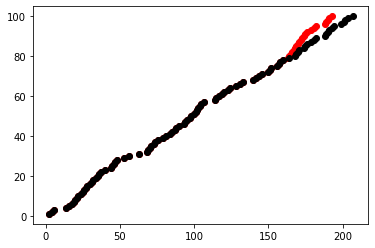

In [309]:

my_rank = ss.rankdata(keyset_per_model[0])
plt.scatter(keyset_per_model[0], my_rank,  color='red')
plt.scatter(keyset_per_model_orig[0], rankset_per_model_orig[0],  color='black')

plt.show()